In [ ]:
# install packages
install.packages('TSA')
install.packages("rugarch")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘zoo’, ‘quantmod’, ‘leaps’, ‘locfit’, ‘tseries’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘misc3d’, ‘truncnorm’, ‘FNN’, ‘kernlab’, ‘mclust’, ‘multicool’, ‘mvtnorm’, ‘plot3D’, ‘pracma’, ‘DistributionUtils’, ‘GeneralizedHyperbolic’, ‘Rsolnp’, ‘ks’, ‘numDeriv’, ‘spd’, ‘chron’, ‘SkewHyperbolic’, ‘Rcpp’, ‘RcppArmadillo’




In [ ]:
# Packages
library(TSA)
library(xts)
library(stats)
library(tseries)
library(rugarch)

In [ ]:
# Variables
chhs_url = "https://data.chhs.ca.gov/dataset/f333528b-4d38-4814-bebb-12db1f10f535/resource/046cdd2b-31e5-4d34-9ed3-b48cdbc4be7a/download/covid19cases_test.csv"

### LOAD DATA
data_chhs <- read.csv(chhs_url)

## Subset Data

In [ ]:
### SUBSET DATA
data_cal <- subset(data_chhs, area_type == 'State')    # subset by state
data_cal_cases <- head(subset(data_cal, select = c ( date, cases)), -2)   # drop last two records
rm(data_cal)
data_cal_cases = na.omit(data_cal_cases)    # omit nas

# convert date from character to date
sapply(data_cal_cases, class)   # class of cols
data_cal_cases$date <- as.Date(data_cal_cases$date, format =  "%Y-%m-%d")
sapply(data_cal_cases, class)   # class of cols

date       cases 
"character"   "numeric"

date     cases 
   "Date" "numeric"

## Daily Data

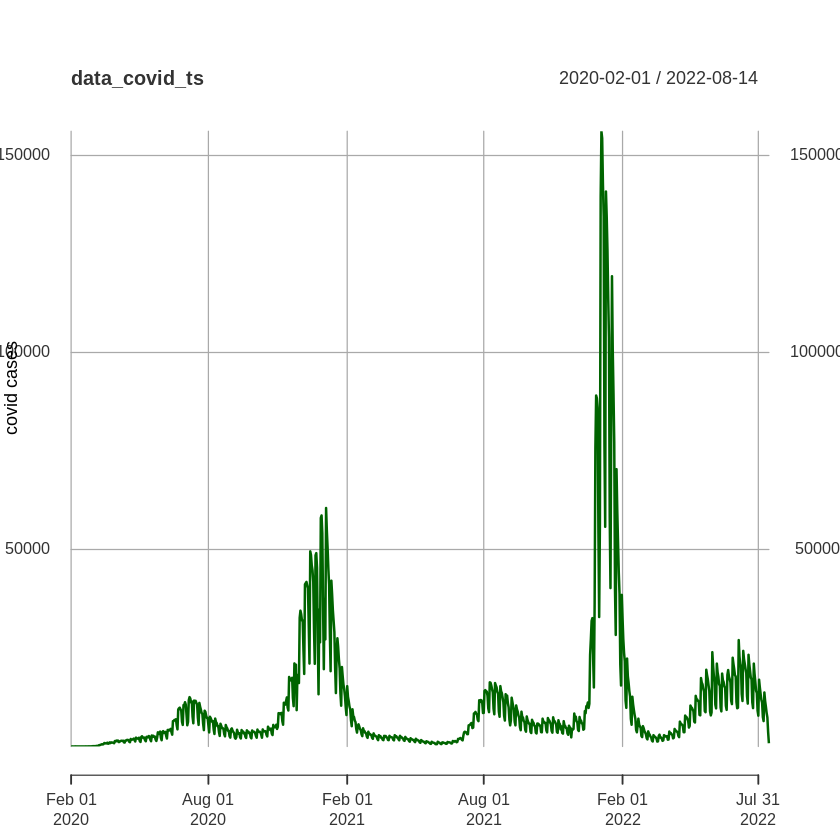

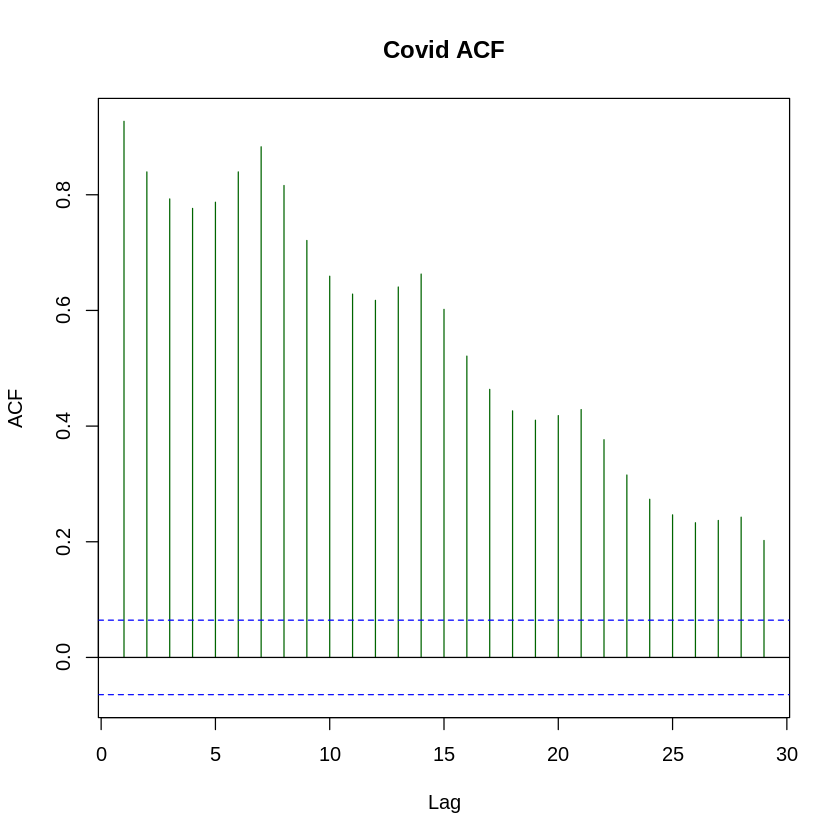

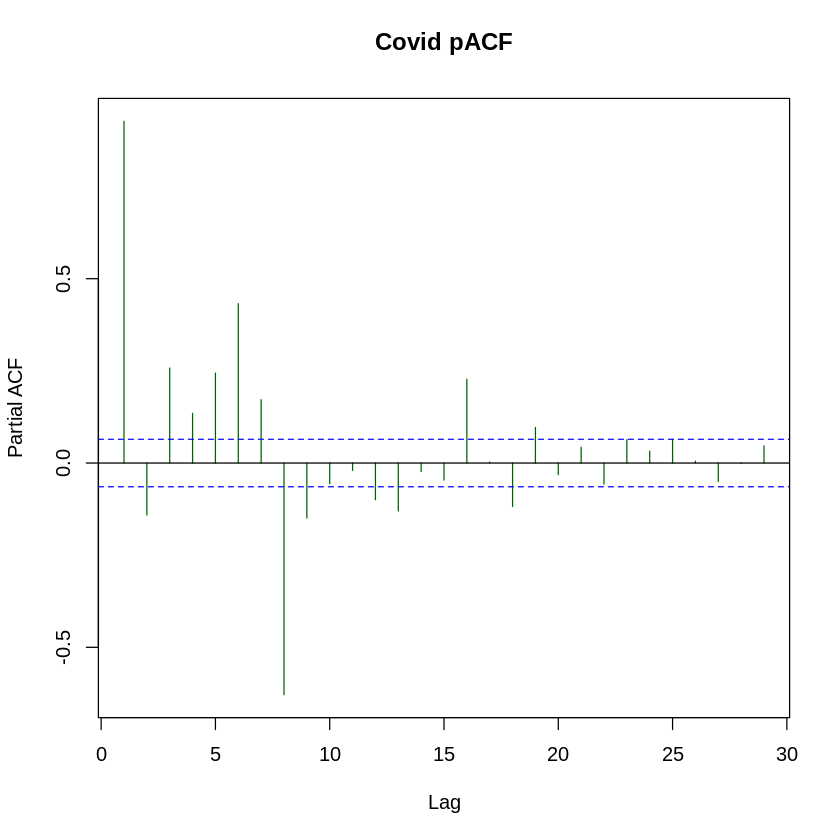

In [ ]:
data_covid_ts = xts(data_cal_cases$cases, order.by = data_cal_cases$date)
plot(data_covid_ts, col='darkgreen', xlab='Days', ylab='covid cases')
acf(data_covid_ts, main='Covid ACF', col='darkgreen')
pacf(data_covid_ts, main= 'Covid pACF', col='darkgreen')




In [ ]:
adf.test(data_covid_ts)

Warning message in adf.test(data_covid_ts):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  data_covid_ts
Dickey-Fuller = -4.4869, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary


In [ ]:
eacf(data_covid_ts, ar.max=15, ma.max=15)

AR/MA
   0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
0  x x x x x x x x x x x  x  x  x  x  x 
1  x x x x x x x x x x x  x  o  x  x  x 
2  x x o o x o x x x o o  x  o  x  x  x 
3  x x o o x o x x x x o  x  o  x  x  x 
4  x o x o o o x x o x o  o  x  x  x  x 
5  x o x o o x x x o x o  o  x  x  x  x 
6  x x x o x x x x x x o  x  o  x  x  x 
7  x x x x x x x x x x x  x  x  x  x  x 
8  x o o x x x o x o x x  o  o  o  x  o 
9  x o o o x o o x o x o  x  o  o  x  o 
10 x o o o x o o x o x o  x  o  o  x  o 
11 x x x o o o o x x x x  x  o  o  o  o 
12 x x x o x o o x o x o  x  o  x  o  o 
13 x x x x x o o x o x x  o  o  x  o  o 
14 x o x x x o x x o o x  x  o  o  o  o 
15 x x x x x x x x x o x  x  x  x  x  o 


In [ ]:
### TEST TRAIN SPLIT
test_size = 60
val_size = 60

data_train = head(data_cal_cases, n= (nrow(data_cal_cases) - (test_size+val_size)))
data_val = tail(head(data_cal_cases, n= (nrow(data_cal_cases) - (test_size))), n=val_size)
data_test = tail(data_cal_cases, n =test_size)
ts_train = xts(data_train$cases, order.by = data_train$date)



## Weekly Data

In [ ]:
### GROUP BY WEEK
data_cases_weeknum <- data_cal_cases
# add week num
data_cases_weeknum$week_num <- strftime(data_cases_weeknum$date, format = "%V")
data_cases_weeknum$year <- format(as.Date(data_cases_weeknum$date, format="%d/%m/%Y"),"%Y")
data_cases_weeknum

library(dplyr)
df_weekly_cases <- data_cases_weeknum %>%
  group_by(week_num, year) %>%
  summarize(date = min(date), cases = sum(cases))

#df_weekly_cases <- df_weekly_cases[rev(order(as.Date(df_weekly_cases$date, format="%m/%d/%Y"))),]
df_weekly_cases <- df_weekly_cases[order(as.Date(df_weekly_cases$date, format="%m/%d/%Y")),]

# drop week num column
keeps <- c("date", "cases")
df_weekly_cases<- df_weekly_cases[keeps]

,date,cases,week_num,year
,<date>,<dbl>,<chr>,<chr>
4641,2020-02-01,24,05,2020
4642,2020-02-02,9,05,2020
4643,2020-02-03,7,06,2020
4644,2020-02-04,1,06,2020
4645,2020-02-05,3,06,2020
4646,2020-02-06,7,06,2020
4647,2020-02-07,32,06,2020
4648,2020-02-08,7,06,2020
4649,2020-02-09,6,06,2020



Attaching package: ‘dplyr’


The following objects are masked from ‘package:xts’:

    first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


`summarise()` has grouped output by 'week_num'. You can override using the
`.groups` argument.


In [ ]:
## Test, train split
test_size = 13
val_size = 15

data_train = head(df_weekly_cases, n= (nrow(df_weekly_cases) - (test_size+val_size)))
data_val = tail(head(df_weekly_cases, n= (nrow(df_weekly_cases) - (test_size))), n=val_size)
data_test = tail(df_weekly_cases, n =test_size)
ts_train = xts(data_train$cases, order.by = data_train$date)

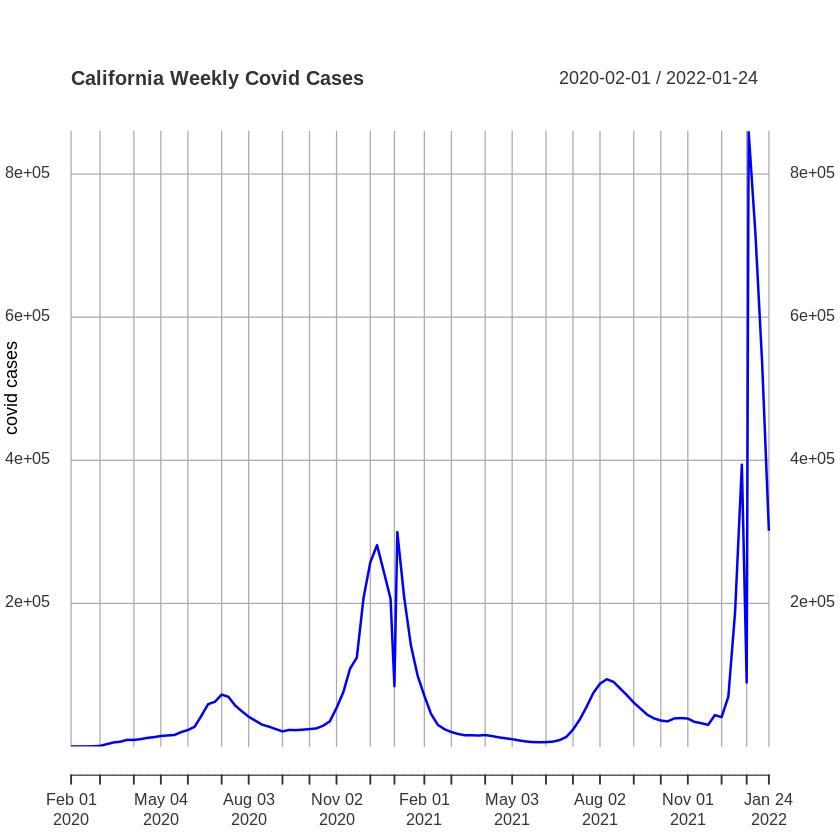

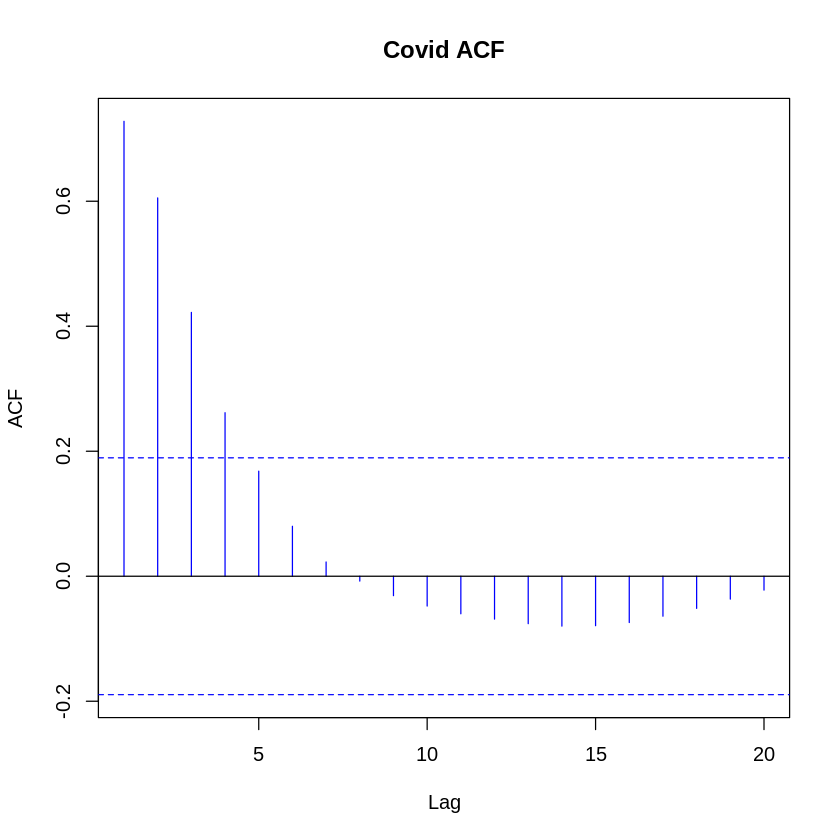

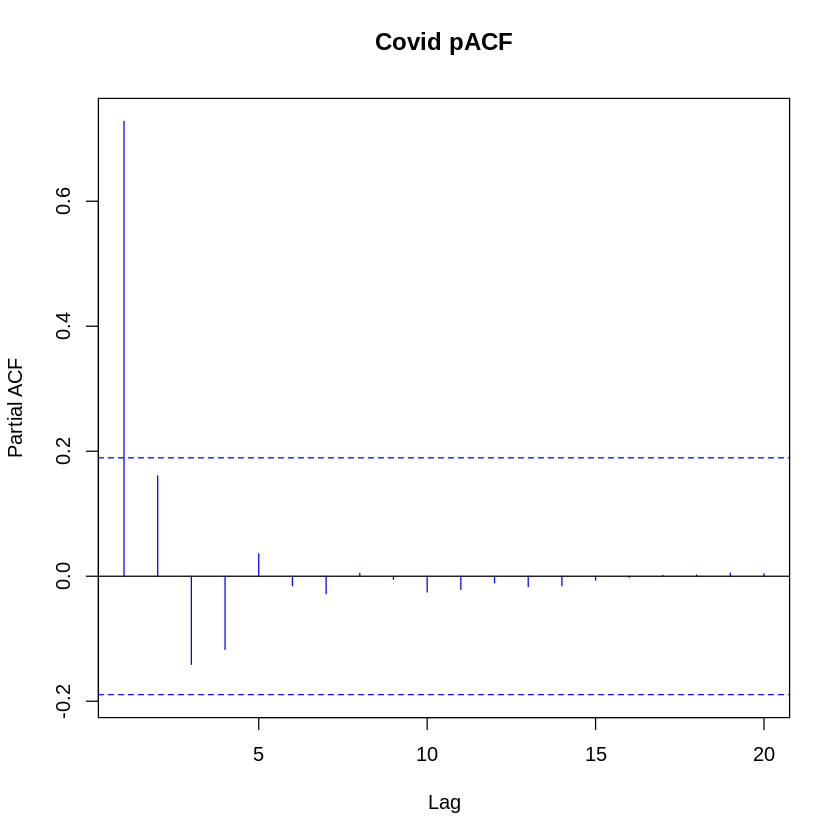

In [ ]:
plot(ts_train, col='blue', xlab='Weeks', ylab='covid cases', main= 'California Weekly Covid Cases')
acf(ts_train, main='Covid ACF', col='blue')
pacf(ts_train, main= 'Covid pACF', col='blue')


In [ ]:
eacf(ts_train)

AR/MA
  0 1 2 3 4 5 6 7 8 9 10 11 12 13
0 x x x x o o o o o o o  o  o  o 
1 x o o x o o o o o o o  o  o  o 
2 o o o x o o o o o o o  o  o  o 
3 x o o o o o o o o o o  o  o  o 
4 o o x x o o o o o o o  o  o  o 
5 o o o o o o o o o o o  o  o  o 
6 o o o o o o o o o o o  o  o  o 
7 x o o o o o o o o o o  o  o  o 


## GARCH

In [ ]:
qpParam <- c(2, 0)
qpGarchParam <- c(1,1)  # c(3, 3) c(8, 0) c(6, 0)



spec <- ugarchspec(variance.model = list(model = "sGARCH", 
                                         garchOrder = qpGarchParam, 
                                         submodel = NULL, 
                                         external.regressors = NULL, 
                                         variance.targeting = FALSE), 
                   
                   mean.model     = list(armaOrder = qpParam, 
                                         external.regressors = NULL, 
                                         distribution.model = "norm", 
                                         start.pars = list(), 
                                         fixed.pars = list()))

garch <- ugarchfit(spec = spec, data = ts_train, solver.control = list(trace=0))


Warning message:
“unidentified option(s) in mean.model:
 distribution.model start.pars fixed.pars”
Warning message in .makefitmodel(garchmodel = "sGARCH", f = .sgarchLLH, T = T, m = m, :
“
rugarch-->warning: failed to invert hessian
”


In [ ]:
garch@fit$coef

mu           ar1           ar2         omega        alpha1 
 9.899291e+04  1.138907e+00 -1.429179e-01  1.739937e+07  8.617518e-01 
        beta1 
 1.372481e-01

In [ ]:
garch@fit$sigma

[1] 100217.117 100217.117  99145.964  36968.760  14320.149   6751.271
  [7]   4865.080   4898.376   4798.993   4541.449   4910.437   4622.146
 [13]   4560.690   4664.053   4530.371   4612.160   4511.313   4495.896
 [19]   5628.374   5014.830   5833.668  14203.574  14448.488   6826.364
 [25]  10030.104   7093.418  11995.593   8640.826   7997.585   6820.277
 [31]   6679.700   5263.550   5539.351   5418.006   5030.524   4639.636
 [37]   4527.098   4510.407   4517.955   5452.859   6723.382  17069.161
 [43]  19238.526  28844.197  15193.620  75848.961  45464.853  23876.521
 [49]  38304.441  33093.919 108803.585 219937.573 138217.831  71932.982
 [55]  40760.123  25896.139  22557.750  14359.122   7862.957   5903.564
 [61]   5248.054   4870.213   4545.619   4544.097   4508.518   4772.435
 [67]   4897.132   4731.764   4715.328   4838.998   4773.994   4630.139
 [73]   4533.811   4499.074   4497.582   4748.560   5681.145   9860.276
 [79]  12684.397  15521.990  17092.265  12151.181   7372.157   6575.935
 [85]   9576.456   9300.299   9909.144   8643.474   8754.800   6527.924
 [91]   5334.204   4712.839   5878.175   4716.574   4610.067   6365.811
 [97]   4952.014   5080.104  13491.354   7939.916  27230.897 106889.158
[103] 179690.416 315831.834 764486.490 365681.298 200200.615

In [ ]:
garch@fit$z

[1] -0.987455186 -0.987155836 -0.004227040 -0.008826536 -0.014128643
  [6]  0.018819735  0.405036631  0.336249561  0.057017565  0.467368728
 [11] -0.177610756  0.159490965  0.289213282  0.086194749  0.244315526
 [16]  0.042448092  0.034142443  0.812711007  0.352979466  0.779870096
 [21]  2.475179176  0.970279446  0.055197975  1.383001155 -0.469493575
 [26] -1.660729829 -0.550036237 -0.751266122 -0.607444333 -0.720943441
 [31] -0.329786671 -0.630221785 -0.541170178  0.391533104 -0.173124772
 [36]  0.087125963  0.086305911  0.112125100  0.736168304  0.962221288
 [41]  2.621730628  1.116050526  1.547476530  0.372077220  5.354719417
 [46]  0.504143517  0.388598342 -1.670896600 -0.832567109 -3.516458719
 [51]  2.140253721 -0.546455152 -0.392399923 -0.457627289 -0.544959285
 [56] -0.831351768 -0.520820518 -0.301283425 -0.410252357 -0.422424796
 [61] -0.327103583 -0.019651576 -0.152396360  0.072428669 -0.384299345
 [66] -0.419652847 -0.286702204 -0.302197814 -0.393371342 -0.328524902
 [71] -0.215345251 -0.107557771 -0.034513190  0.053933782  0.368971802
 [76]  0.778650791  1.646443942  1.246358317  1.205377670  1.078898669
 [81]  0.598418645  0.362115226 -0.626523963 -1.354556976 -0.845598755
 [86] -0.961581022 -0.719742087 -0.872347069 -0.471677195 -0.376507361
 [91] -0.192249582  0.858450788 -0.059204378 -0.204295127 -1.050402291
 [96] -0.211444384 -0.488479900  2.691229206 -0.362939160  3.629014232
[101]  4.206333822  1.765902313 -1.850683829  2.576730486 -0.325899865
[106] -0.434043102 -1.033897672

In [ ]:
str(garch)

ERROR while rich displaying an object: Error in t.default(grad): argument is not a matrix

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_text.default(obj)
8. paste(capture.output(print(ob

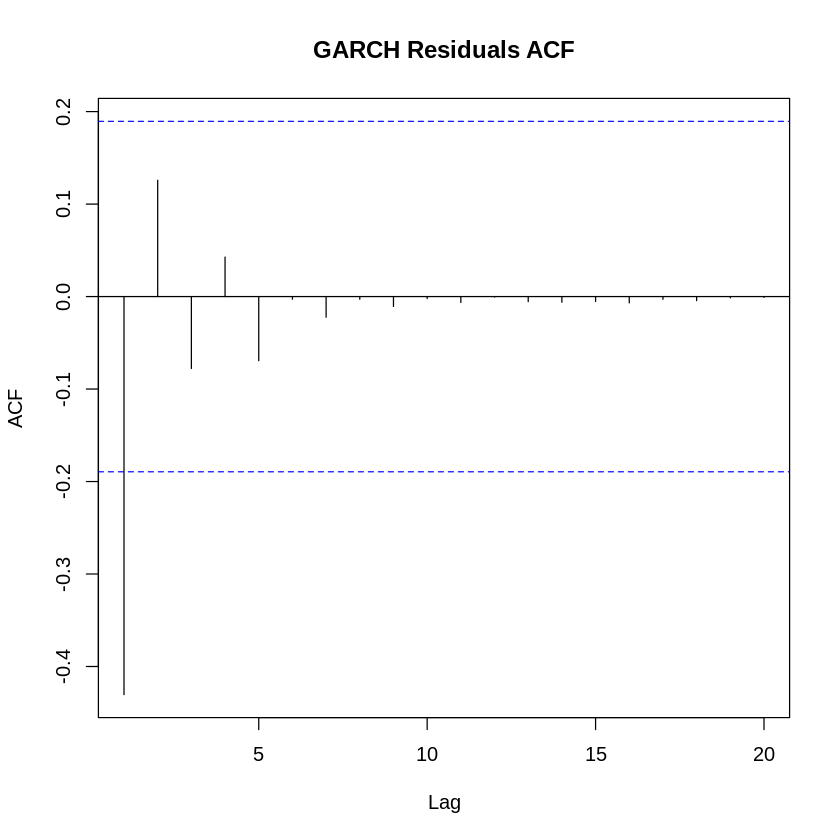

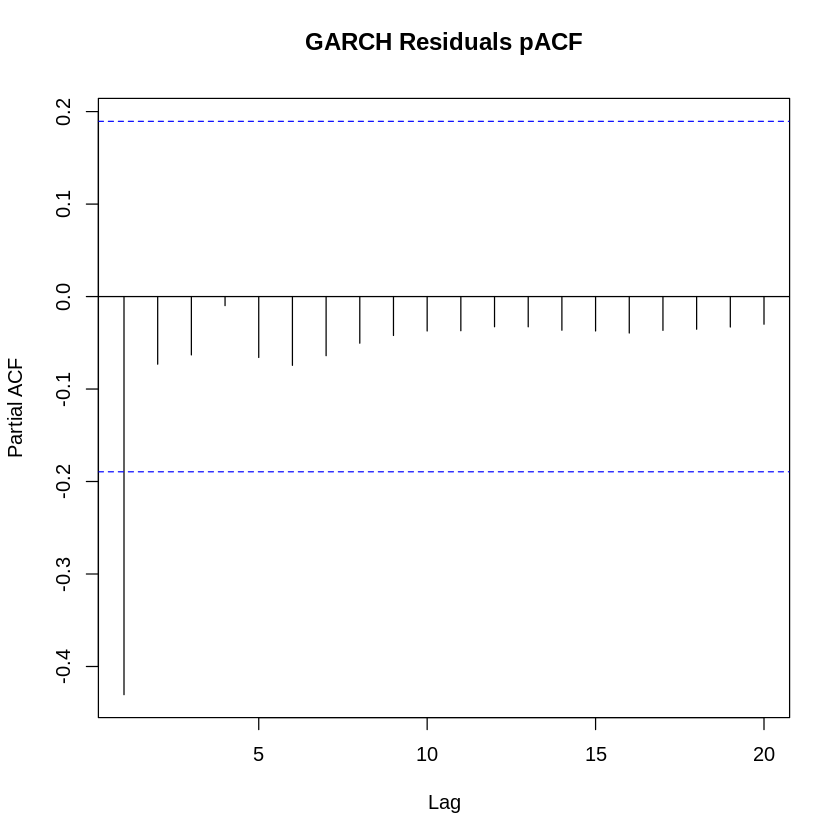

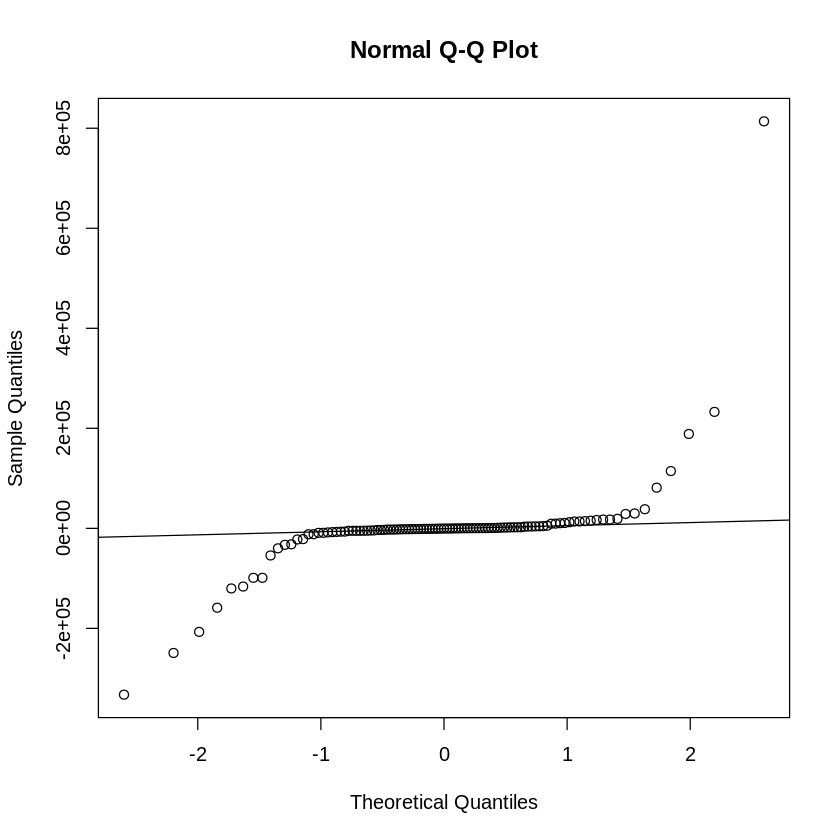

In [ ]:
# garch resiudals
# Resiudals
garchResiduals <- garch@fit$residuals
acf(garchResiduals, main='GARCH Residuals ACF')
pacf(garchResiduals, main='GARCH Residuals pACF')
qqnorm(garchResiduals)
qqline(garchResiduals)